In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, cross_val_score,KFold
from sklearn.metrics import f1_score,confusion_matrix,roc_curve,roc_auc_score,accuracy_score
from joblib import dump,load


from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
# Dropping the first column since it was a repitition of the index column
df_train=pd.read_csv('cs-training.csv').iloc[:,1:]
df_test=pd.read_csv('cs-test.csv').iloc[:,1:].drop('SeriousDlqin2yrs',axis=1)

df_train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
print(f'Training set has {df_train.shape[0]} rows and {df_train.shape[1]} columns')
print(f'Test set has {df_test.shape[0]} rows and {df_test.shape[1]} columns')

Training set has 150000 rows and 11 columns
Test set has 101503 rows and 10 columns


In [4]:
# Identifying columns with missing values

np.round(100*df_train.isnull().sum()/len(df_train),2)

SeriousDlqin2yrs                         0.00
RevolvingUtilizationOfUnsecuredLines     0.00
age                                      0.00
NumberOfTime30-59DaysPastDueNotWorse     0.00
DebtRatio                                0.00
MonthlyIncome                           19.82
NumberOfOpenCreditLinesAndLoans          0.00
NumberOfTimes90DaysLate                  0.00
NumberRealEstateLoansOrLines             0.00
NumberOfTime60-89DaysPastDueNotWorse     0.00
NumberOfDependents                       2.62
dtype: float64

<AxesSubplot:ylabel='MonthlyIncome'>

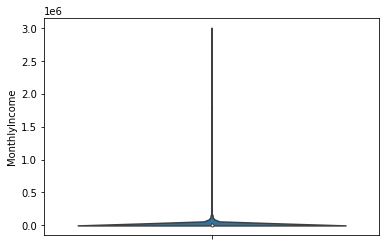

In [5]:
# Visualizing the monthly income column

sns.violinplot(data=df_train,y='MonthlyIncome')

In [6]:
# Imputing missing values in the monthly income column with the median income
income_med=df_train['MonthlyIncome'].median()
df_train['MonthlyIncome']=df_train['MonthlyIncome'].fillna(income_med)
df_test['MonthlyIncome']=df_test['MonthlyIncome'].fillna(income_med)

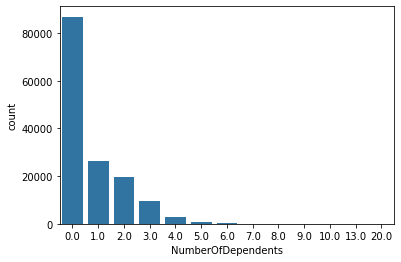

In [7]:
# Visualizing number of dependents 
base_color=sns.color_palette()[0]
sns.countplot(data=df_train,x='NumberOfDependents',color=base_color);

In [8]:
df_train['NumberOfDependents']=df_train['NumberOfDependents'].fillna(0)
df_test['NumberOfDependents']=df_test['NumberOfDependents'].fillna(0)

C:\Users\stone\anaconda3\envs\creditdefault\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


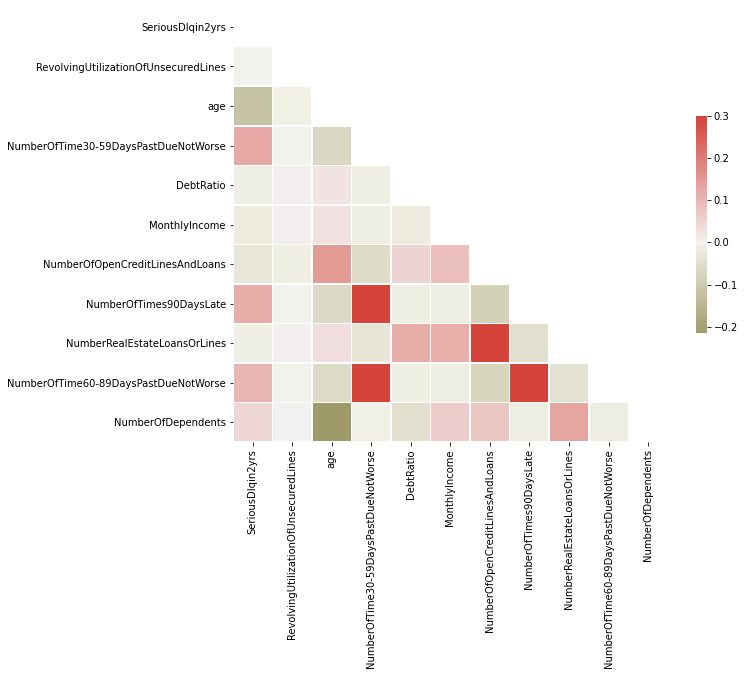

In [9]:
# Calculating the correlation matrix between different variables
corr_matrix=df_train.corr()

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(800, 14, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [10]:
X,y=df_train.drop('SeriousDlqin2yrs',axis=1),df_train['SeriousDlqin2yrs']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=42)
print('training set',[X_train.shape,y_train.shape])
print('test set',[X_test.shape,y_test.shape])

training set [(135000, 10), (135000,)]
test set [(15000, 10), (15000,)]


In [11]:
sm=SMOTE(random_state=21)
X_train,y_train=sm.fit_resample(X_train,y_train)

In [12]:
y_train.value_counts()

0    125935
1    125935
Name: SeriousDlqin2yrs, dtype: int64

In [13]:
sc=StandardScaler()
X_train_scaled=sc.fit_transform(X_train)
X_test_scaled=sc.transform(X_test)
df_test_scaled=sc.transform(df_test)

In [14]:
#dump(sc,'stan_scaler.bin')
sc1=load('stan_scaler.bin')

In [15]:
import pickle
model = pickle.load(open('xgb_model.pkl', 'rb'))

In [16]:
f1_score(y_test,model.predict(X_test_scaled))

0.361532899493854

In [21]:
n_unsec = 0.76
age=45
debt_ratio=0.80
income=9120
n_open_lines=13
n_90=0
n_real=6
n_60_89=0
n_dep=2
n_30_59=2

In [30]:
prediction=model.predict(sc1.transform(np.array([[n_unsec,age,n_30_59,debt_ratio,income,n_open_lines,n_90,n_real,n_60_89,n_dep]])))[0]

prediction

1

a1=1,a2=2
